# Handcrafted Molecular Fingerprint Descriptor

In [2]:
!pip install jpype1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 12.1 MB/s eta 0:00:0000:01


In [3]:
!pip install rdkit-pypi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 35.7 MB/s eta 0:00:0000:0100:01


In [4]:
from jpype import isJVMStarted, startJVM, getDefaultJVMPath, JPackage
if not isJVMStarted():
    cdk_path = '/kaggle/input/cdk-2-7-1/cdk-2.7.1.jar'
    startJVM(getDefaultJVMPath(), "-ea", "-Djava.class.path=%s" % cdk_path)
    cdk =  JPackage('org').openscience.cdk
    print("JVMStarted is success")

JVMStarted is success


In [5]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

def featsmi(fp_type, smis, size=1024, depth=6):
    fg = {
        
        "CKD": cdk.fingerprint.Fingerprinter(size, depth),
        "CKDExt": cdk.fingerprint.ExtendedFingerprinter(size, depth),
        "PubChem": cdk.fingerprint.PubchemFingerprinter(cdk.silent.SilentChemObjectBuilder.getInstance()),
        "Estate": cdk.fingerprint.EStateFingerprinter(),
        "FP4C": cdk.fingerprint.SubstructureFingerprinter(),
    }

    # Handle CDK smiles parser
    sp = cdk.smiles.SmilesParser(cdk.DefaultChemObjectBuilder.getInstance())

    for i, smi in enumerate(smis):
        if fp_type == "RDKit":
            # Convert SMILES to RDKit Mol object
            mol = Chem.MolFromSmiles(smi)
            if mol is None:
                raise ValueError(f"Invalid SMILES: {smi}")
            
            # Compute RDKit Morgan Fingerprint
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)

            #fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=size)
            feat = np.zeros((1, size), dtype=int)
            AllChem.DataStructs.ConvertToNumpyArray(fp, feat)
            feat = feat.flatten()
        else:
            # Handle CDK-based fingerprints
            mol = sp.parseSmiles(smi)
            fingerprinter = fg[fp_type]
            nbit = fingerprinter.getSize()
            if fp_type == "KRC" or fp_type == "FP4C":
                fp = fingerprinter.getCountFingerprint(mol)
                feat = np.array([int(fp.getCount(i)) for i in range(nbit)])
            else:
                fp = fingerprinter.getFingerprint(mol)
                feat = np.array([int(fp.get(i)) for i in range(nbit)])

        # Stack the features
        if i == 0:
            featx = feat.reshape(1, -1)
        else:
            featx = np.vstack((featx, feat.reshape(1, -1)))

    return featx


In [6]:
from rdkit import Chem
from rdkit.Chem import AllChem

#def featex(smis, y_all):
def featex(smis):
    fname = []
    fused = []
    #y_df = pd.DataFrame(y_all)  # Convert feat0 to a DataFrame

    
  

    feat1 = featsmi("CKD", smis); fname.append("CKD"); fused.append(1)
    feat1_df = pd.DataFrame(feat1)  # Convert feat1 to a DataFrame
    #feat1_df = pd.concat([feat1_df, y_df], axis=1)
    feat1_df.to_csv("CKD.csv", index=True)

    feat2 = featsmi("CKDExt", smis); fname.append("CKDExt"); fused.append(2)
    feat2_df = pd.DataFrame(feat2)  # Convert feat2 to a DataFrame
    #feat2_df = pd.concat([feat2_df, y_df], axis=1)
    feat2_df.to_csv("CKDExt.csv", index=True)

    feat3 = featsmi("PubChem", smis); fname.append("PubChem"); fused.append(3)
    feat3_df = pd.DataFrame(feat5)  # Convert feat5 to a DataFrame
    #feat5_df = pd.concat([feat5_df, y_df], axis=1)
    feat3_df.to_csv("PubChem.csv", index=True)

    feat4 = featsmi("FP4C", smis); fname.append("FP4C"); fused.append(4)
    feat4_df = pd.DataFrame(feat9)  # Convert feat9 to a DataFrame
    #feat9_df = pd.concat([feat9_df, y_df], axis=1)
    feat4_df.to_csv("FP4C.csv", index=True)


    
    
    allfeat_pos = np.hstack((
                             feat1, 
                             feat2, 
                             feat3, 
                             feat4,

                            ))
    f = []
    before = 0
    for i in fused:
        after = before + eval('feat%d.shape[1]'% (i))
        f.append(list(range(before, after)))
        before = after
        
    return allfeat_pos, f, fname 

In [7]:
import pandas as pd
import numpy as np
df = pd.read_csv('Raw Training set.csv')

smiles = df['Smiles'].values
#y_all = df['cls'].values

#Xall, f, fname = featex(smiles,y_all)
Xall, f, fname = featex(smiles)

# Mol2Vec  Molecular Descriptor

In [1]:
!pip install rdkit-pypi
!pip install pandas==0.23.0
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

!pip install git+https://github.com/samoturk/mol2vec;

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 50.5 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 44.1 MB/s eta 0:00:0000:010:01
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Cloning https://github.com/samoturk/mol2vec to /tmp/pip-req-build-gvpwreb_
  Running command git clone --filter=blob:none --quiet https://github.com/samoturk/mol2vec /tmp/pip-req-build-gvpwreb_
  Resolved https://github.com/samoturk/mol2vec to commit 850d944d5f48a58e26ed0264332b5741f72555aa
  Preparing metadata (setup.py) ... done


In [2]:
import pandas as pd
# นำเข้าข้อมูล
mdf = pd.read_csv('/kaggle/input/gamma-raw/cleaned_gamma_reg.csv')
#mdf = mdf[mdf['Class'] != 'intermediate']
#mdf =mdf.loc[0:3]
#smiles_name = mdf['Name'].values
smiles = mdf['Smiles'].values

# Define y
#y_all = mdf['cls'].values
#y_df = pd.DataFrame(y_all)

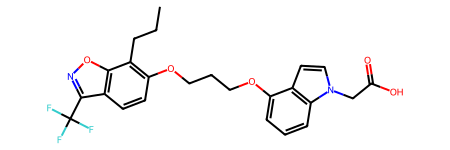

In [4]:
from rdkit import Chem 
#Transforming SMILES to MOL
mdf['mol'] = mdf['Smiles'].apply(lambda x: Chem.MolFromSmiles(x))

mdf['mol'][193]

In [14]:

import numpy as np
import pandas as pd
from mol2vec.features import mol2alt_sentence, MolSentence, sentences2vec
from gensim.models import Word2Vec
from rdkit import Chem  # Import the Chem module

# Assuming 'model' is the 100-dimensional Mol2Vec model (make sure you're using the 100-dimensional model)
model = Word2Vec.load("model_300dim.pkl")
mdf['mol'] = mdf['Smiles'].apply(lambda x: Chem.MolFromSmiles(x))

# Replace 'model.wv.vocab' with 'model.wv.key_to_index'
def sentences2vec_updated(sentences, model, unseen='UNK'):
    keys = set(model.wv.key_to_index.keys())
    vec = []
    for word in sentences:
        if word in keys:
            vec.append(model.wv[word])
        else:
            vec.append(model.wv[unseen])
    return np.array(vec)  # Convert the list to a numpy array

# Function to apply Mol2Vec to the entire DataFrame and save to CSV
def save_mol2vec_features(mdf, model, output_csv='mol2vec_features.csv'):
    features = []
    for idx, row in mdf.iterrows():
        # Convert SMILES to Mol object
        mol_sentence = mol2alt_sentence(row['mol'], radius=9)
        sentence_obj = MolSentence(mol_sentence)
        
        # Get the Mol2Vec feature vector for the sentence
        vector = sentences2vec_updated(sentence_obj, model, unseen='UNK')
        
        # No need to truncate or pad if you're using the 100-dimensional Mol2Vec model
        # Perform averaging across the word vectors to create a single vector
        vector = np.mean(vector, axis=0)

        # Flatten the vector into a 1D array
        features.append(vector.flatten())  # Flatten to a 1D array for each molecule
    
    # Convert list of feature vectors into a DataFrame
    feature_df = pd.DataFrame(features)
    
    # Save the DataFrame to a CSV file
    #feature_df = pd.concat([feature_df, y_df], axis=1)
    feature_df.to_csv(output_csv, index=True)
    print(f"Mol2Vec features saved to {output_csv}")

# Assuming 'mdf' is your DataFrame and it has a 'mol' column with SMILES strings
# Apply the function to save features to CSV

save_mol2vec_features(mdf, model, output_csv='R9D300.csv')  # Using the 100-dimensional model


Mol2Vec features saved to R9D300.csv


[09:38:36] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 10 11 12 13
[09:38:37] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[09:38:38] Explicit valence for atom # 8 N, 4, is greater than permitted
[09:38:38] Explicit valence for atom # 8 N, 4, is greater than permitted
[09:38:39] Explicit valence for atom # 10 O, 3, is greater than permitted
[09:38:39] Explicit valence for atom # 14 N, 4, is greater than permitted
[09:38:40] Explicit valence for atom # 0 F, 2, is greater than permitted
[09:38:40] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 9 10 11
[09:38:41] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[09:38:41] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 8 9 10 11
[09:38:42] Explicit valence for atom # 36 N, 4, is greater than permitted
[09:38:43] Explicit valence for atom # 9 F, 2, is greater than permitted
[09:38:43] Explicit valence for atom # 1 N, 4, is greater than permitted
[09:38:43] Explicit valence for atom # 0 O, 8, is greater than

Skipping invalid SMILES at index 5688
Skipping invalid SMILES at index 10590
Skipping invalid SMILES at index 11321
Skipping invalid SMILES at index 13873
Skipping invalid SMILES at index 18489
Skipping invalid SMILES at index 19968
Skipping invalid SMILES at index 20995
Skipping invalid SMILES at index 22085
Skipping invalid SMILES at index 25216
Skipping invalid SMILES at index 26112
Skipping invalid SMILES at index 33662
Skipping invalid SMILES at index 35618
Skipping invalid SMILES at index 37018
Skipping invalid SMILES at index 38029
Skipping invalid SMILES at index 41147
Skipping invalid SMILES at index 61298
Skipping invalid SMILES at index 66035
Skipping invalid SMILES at index 66562
Skipping invalid SMILES at index 71553
Skipping invalid SMILES at index 71709
Skipping invalid SMILES at index 81746
Skipping invalid SMILES at index 85961
Skipping invalid SMILES at index 88091
Skipping invalid SMILES at index 89939
Skipping invalid SMILES at index 89952
Mol2Vec features saved to 